# MPlot tutorial (ts_step = 2)

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks is a tutorial of how to use the different methods defined in mplots.ipyn for the specific case of 'PulsusParadoxus'.

## What is an MPlot?
MPlots were introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)

It also integrates methods of Stumpy:
- [Tutorial: The Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Time-Series-with-Length-n-=-13)

Feel free of modifying the parameters and open issue in case of error!

**Note**

For the example in this notebook, the instructions in [Introducing Mplots: Scaling Time Series Recurrence Plots to Massive Datasets](https://web.archive.org/web/20240125145941id_/https://assets.researchsquare.com/files/rs-3651179/v1_covered_ef5f7e93-ace3-4376-b6f6-3021b43d586c.pdf?c=1701243102) have been followed. You can check more examples in [MPlots-pdf-Catalog](https://drive.google.com/file/d/1fjWUzVQf-8XmS5epDa_ulm4-bDX51Vxv/view). You will also find lots more datasets at his GoogleDrive. [This powerpoint](https://www.slideserve.com/mickie/ucr-time-series-semantic-segmentation-archive-powerpoint-ppt-presentation) explains the content of some of them in a simple way, including the Pulsus Paradoxus dataset.

## Notebook configuration
### Parameters

The parameters in this notebook are only some of the input parameters you can define for the *06-Mplot* notebook. In that notebook the configuration parameters are included in the first cell and fully explained as needed. 

Here you got:

- `verbose`. If `> 0` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `cuda_device`. Integer used to define the GPU machine to be used for computation. Please ensure it is an id number valid for the built docker (check your .env file to know the valid ids)
- `execute_01`. Put this flag to true in case you have never executed the 01_<> notebook for the PulsusParadoxus dataset. Please change it to false one the celss in the section `Execute '1` have already been executed. It does not take very long, but it is some time ;).

In [1]:
#| export
# Configuration paramaters
verbose                       = 1
reset_kernel                  = False
check_memory_usage            = True
time_flag                     = True
cuda_device                   = 1
execute_01                    = False

In [2]:
print("--- Check parameters ---")
print(
    "verbose (for printing or not messages):", verbose, "\n",
    "check_memory_usage (for evaluating the current gpu memor status)", check_memory_usage, "\n",
    "time_flag:", time_flag, "\n",
    "reset_kernel:",reset_kernel, "\n",
    "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
print_flag (for printing or not messages): True 
 check_memory_usage (for evaluating the current gpu memor status) True 
 time_flag: True 
 reset_kernel: False 
 cuda_device 1 



### VsCode update patch
Initial notebook setup when using VSCode.

In [3]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

## Import libraries

In [4]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
warnings.simplefilter('always', UserWarning)
import os
import sys
sys.path.append(os.path.abspath('..'))
import dvats.config as cfg_
import dvats.mplots as mplots
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb


Octave is ready <oct2py.core.Oct2Py object at 0x7f5153263a30>

















## Execute 01 notebook
If you haven't executed the 01_<> notebook, execute the next 5 code cells

Please be sure that you have already downloaded the PulsusParadoxus dataset into your local path 
deepvats\..\data\ as .csv . You can check it with the next cell. It can be downloaded from [segData](https://drive.google.com/file/d/1mJs_FSjSnffw2xPJhu3SlES2kXSCMoNy/view). Unzip the folder and get the `PulsusParadoxusSP02_30_10000.txt` file and change the extension to `.csv` so you can execute the code. There are some utilities function if you can do it directly here in the `nbs\mplots.ipybn` notebook, but they are not relevant for this tutorial. If you want, just take a look and if you think it is usefull, make a pull requests with the changes to add here the downloading lines using those utilities functions. Thanks!

In [5]:
#warnings.filterwarnings('ignore', category=UserWarning)
pulsus_path = "~/data/home/macu/data/PulsusParadoxusSP02_30_10000.csv"
pulsus_path = os.path.expanduser(pulsus_path)
print(pulsus_path)
! ls {pulsus_path}

/home/macu/data/home/macu/data/PulsusParadoxusSP02_30_10000.csv
ls: cannot access '/home/macu/data/home/macu/data/PulsusParadoxusSP02_30_10000.csv': No such file or directory


In [6]:
#-- For setting up the parameters
import os
import torch
from typing import Tuple, Dict

#-- Specific
from ploomber_engine import execute_notebook

##### Ensure the correct configuration for ploomber engine execution

In [7]:
filename = "01_dataset_artifact"
parameters = {
    'verbose'                       : 0,
    'show_plots'                    : False,
    'reset_kernel'                  : False,
    'pre_configured_case'           : False,
    'case_id'                       : 7,
    'frequency_factor'              : 1,
    'frequency_factor_change_alias' : True,
    'cuda_device'                   : torch.cuda.current_device()
}

In [8]:
def get_input_output(nb_id: int) -> Tuple[ str, str, Dict ]:
    print(filename)
    print(parameters)
    inbpath    = os.path.expanduser('~/work/nbs_pipeline')
    onbpath    = os.path.expanduser('~/work/nbs_pipeline/output')
    extension  = ".ipynb"
    reportname = filename+"-output"
    inputnb    = inbpath+"/"+filename+extension
    outputnb   = onbpath+"/"+reportname+extension
    print(f"Executing {inputnb} into {outputnb}")
    return inputnb, outputnb, parameters

##### Execute 01

In [9]:
if execute_01:
    warnings.simplefilter('ignore', UserWarning)
    inputnb, outputnb, parameters = get_input_output(1)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

## Initialize and Configurate Artifact

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;The following cells can be skipped as they are configuration cells. Continue until the next warning.
    </div>
</div>

### Initialize Weights and Biases

In [10]:
#| export
wandb_api = wandb.Api()

### Setup CUDA

In [11]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 14
GPU | Used mem: 24
GPU | Memory Usage: [███████████---------] 58%


### Get configutation from yml
> This file used the configuration files './config/base.yml'

In [12]:
# Ensure the correct execution path 
# Se puede hacer mejor con la ultima versión que hay en master del config.ipybn
# En esa versión se permite pasar paths por parámetro a las funciones de configuración
# Así no hay por qué forzar aquí path de ejecución
# Y se gana, además, bastante versatilidad

target_directory = os.path.expanduser("./work/nbs_pipeline")
print(target_directory)
%cd {target_directory}
#! ls

./work/nbs_pipeline
[Errno 2] No such file or directory: './work/nbs_pipeline'
/home/macu/work/nbs_pipeline


In [13]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

### Setup Weights & biases artiffact

In [14]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="_MPlot_PulsusParadoxus"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if verbose > 0: print("runname: "+runname)
if verbose > 0: cfg_.show_attrdict(config)

runname: _MPlot_PulsusParadoxus
alias: PulsusParadoxus-SP02
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (1, 100)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 900
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 100
wandb_group: None


In [15]:
job_type = 'MPlot'
job_type

'MPlot'

## Start W&B Run

In [16]:
#| export
if verbose > 0: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if verbose > 0: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;End of the skippable cells.
    </div>
</div>

## Get the time series data
### Get W&B train artifact

In [17]:
#| export
config = run.config  # Object for storing hyperparameters
if verbose > 0: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if verbose > 0: print("---> W&B Train Artifact")

alias: PulsusParadoxus-SP02
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [1, 100]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 900
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 100
wandb_group: None
---> W&B Train Artifact


### Transform to dataframe

In [18]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [19]:
#| export
if verbose > 0: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(17521, 1)


<bound method NDFrame.head of                             0
1970-01-01 00:00:00 -1.193829
1970-01-01 00:00:01 -1.193829
1970-01-01 00:00:02 -1.193829
1970-01-01 00:00:03 -1.262998
1970-01-01 00:00:04 -1.286055
...                       ...
1970-01-01 04:51:56  0.601779
1970-01-01 04:51:57  0.475591
1970-01-01 04:51:58  0.475591
1970-01-01 04:51:59  0.297443
1970-01-01 04:52:00  0.119295

[17521 rows x 1 columns]>

df_train ~  (17521, 1)
window_sizes =  [1, 100]
wlen =  100


## Check the MatrixProfile

In [20]:
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 14
GPU | Used mem: 24
GPU | Memory Usage: [███████████---------] 58%


### Initialize parameters

In [21]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = dvats.mplots.scamp.gpu_supported()
has_gpu_support

True

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

### Get the time series data

In [128]:
df_train.shape

(17521, 1)

In [22]:
# Use step for selecting values in position k*step 
ts_step = 2
ts_full = df_train.iloc[:, 0].values
ts = df_train.iloc[:, 0].values[::ts_step] #For some reason. Trying to follow MPlot-figures-ref

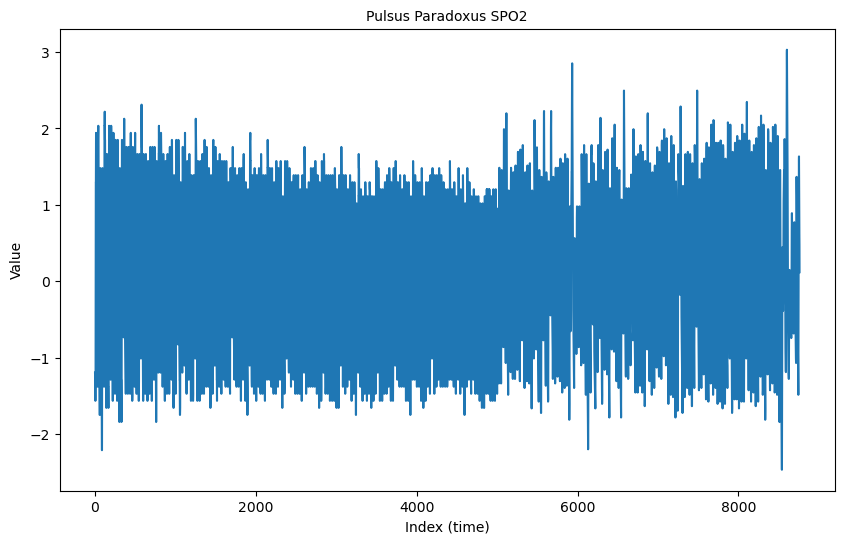

In [23]:
mplots.plot_with_dots(
    time_series = ts, 
    title = "Pulsus Paradoxus SPO2", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False
)

### Build the MatrixProfile object

In [24]:
pulsus_mp = mplots.MatrixProfile(
    data      = ts, 
    data_b    = ts, 
    self_join = False
) #Some error in naive, use it like this

### Choose window length
Eamon et all use ''approximately 1 pulsus'': m = 50. 
Let's see what does Fourier transform detect

In [25]:
pulsus_mp.provide_lens(1)
pulsus_mp.dominant_lens

[13]

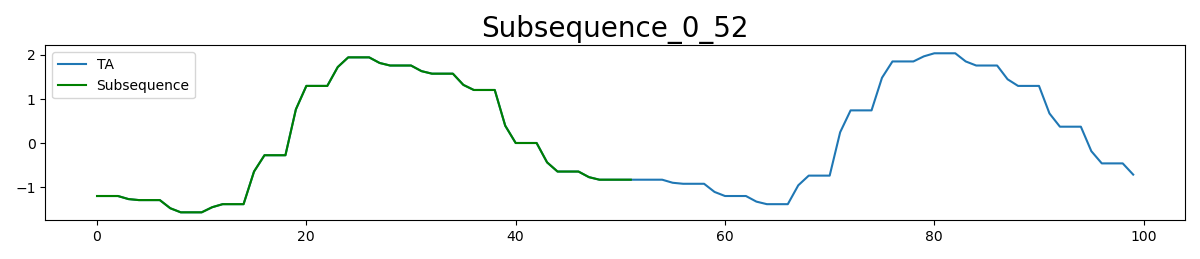

In [85]:
mplots.plot_subsequence(
    TA = ts_full[:100], 
    sequence_i = 0,
    subsequence_len = pulsus_mp.subsequence_len,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

And what happens if we use the double?

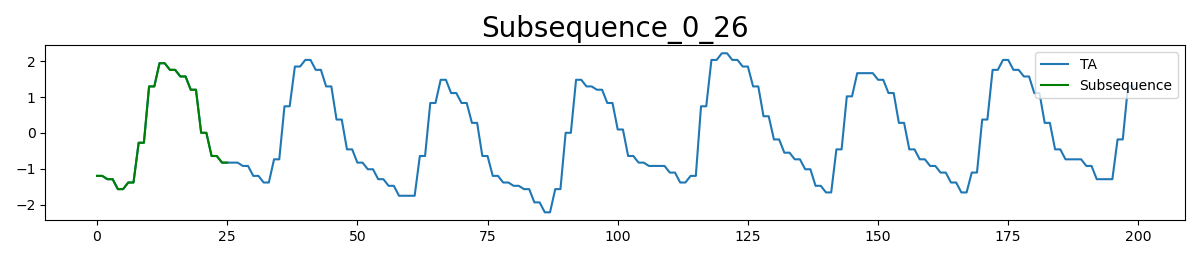

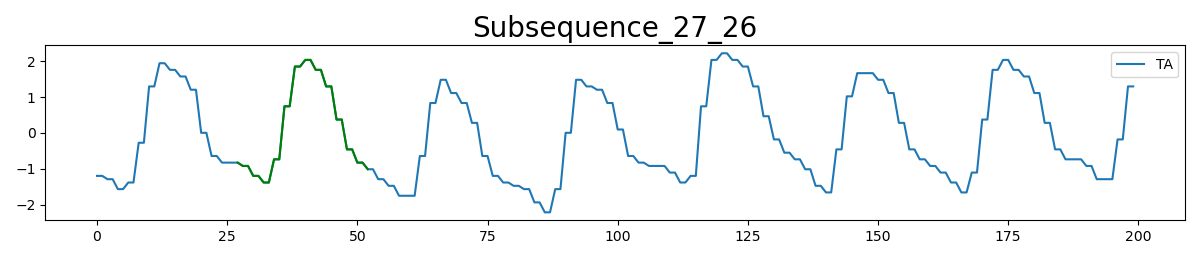

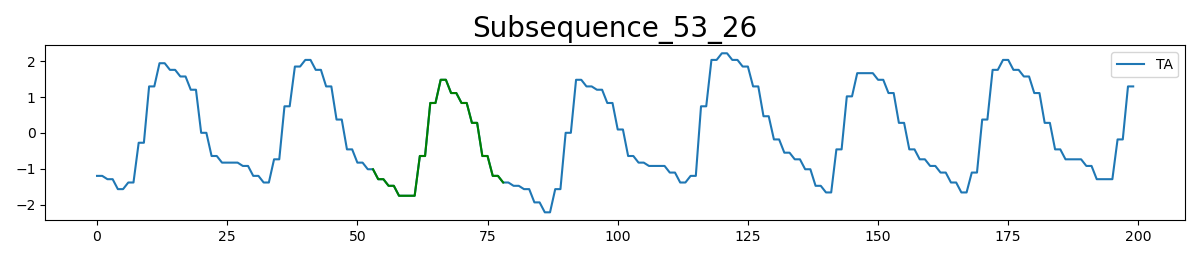

In [90]:
length = int(pulsus_mp.subsequence_len/ts_step)
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = 0,
    subsequence_len = length,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = length+1,
    subsequence_len = length,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = 2*length+1,
    subsequence_len = length,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

This value seems to correspond to that idea of getting 'one pulsus' as subsequence length

### Compute the Matrix Profile

In [28]:
pulsus_mp.subsequence_len = pulsus_mp.dominant_lens[0]*2*ts_step

In [29]:
pulsus_mp.compute(
    verbose = verbose, 
    d = mplots.z_normalized_euclidean_distance, 
    method = 'stump'
)

--> matrix profile
--> Stump (CPU)
MP | Compute | Using stumpy.stump | normalize? True
matrix profile 20.685336351394653 seconds -->


array([0.7133067490755893, 0.7019061719071555, 0.6899289065110475, ...,
       0.7250217071761418, 0.7153993301984543, 0.7365570025220421],
      dtype=object)

In [30]:
len(pulsus_mp.index)

8710

### Visualization of the matrix profile

With the interactive plot we can visually check the motif and anomaly indexes.
The previous and next buttons can be used for going subsequence by subsequence whereas the Motif and Discord buttons show the associated subsequences.

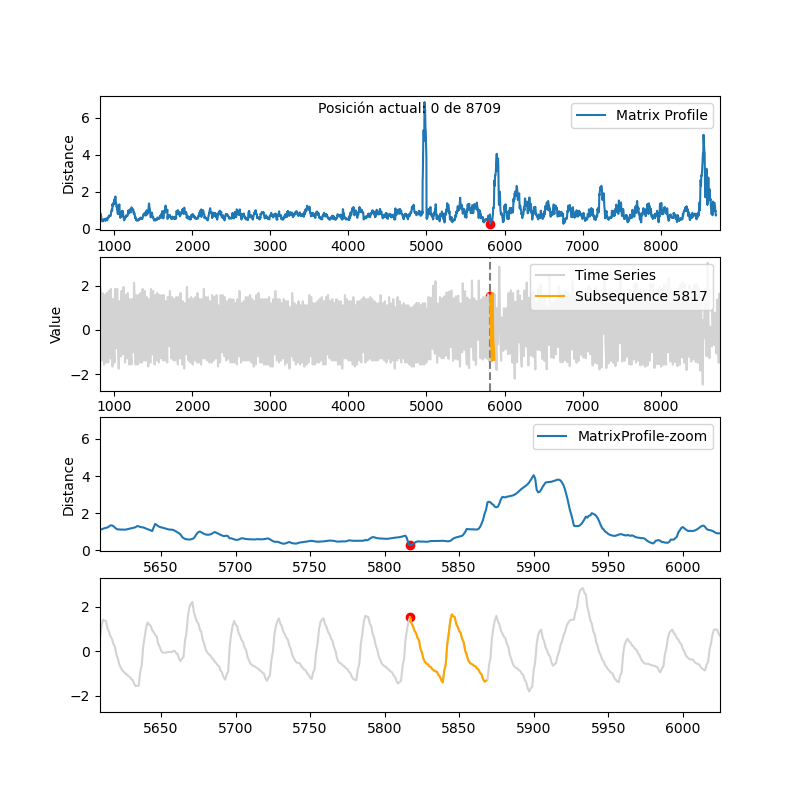

In [31]:
%matplotlib widget
pulsus_mp.plot_interactive(
    figsize = (8,8),
    verbose = verbose
)

### Direct computation & related metadata

#### Motif

In [32]:
pulsus_mp.get_motif_idx(verbose = verbose)

motif id 5817 index ~  8710


(5817, 6755, 5349, 6755)

In [33]:
print(pulsus_mp.motif_idx)
print(pulsus_mp.motif_nearest_neighbor_idx)
print(pulsus_mp.motif_nearest_neighbor_idx_left)
print(pulsus_mp.motif_nearest_neighbor_idx_right)


5817
6755
5349
6755


#### Discord/Anomaly

In [34]:
pulsus_mp.get_anomaly_idx(verbose = verbose)

motif id 4975 index ~  8710
Nearest  4952
Nearest left  4952
Nearest right  6168


(4975, 4952, 4952, 6168)

In [35]:
print(pulsus_mp.discord_idx)
print(pulsus_mp.discord_nearest_neighbor_idx)
print(pulsus_mp.discord_nearest_neighbor_idx_left)
print(pulsus_mp.discord_nearest_neighbor_idx_right)

4975
4952
4952
6168


## Check the MPlot

### Build the MatrixProfilePlot object

In [36]:
pulsus_mp.subsequence_len

52

In [37]:
pulsus_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [38]:
#| hide
print("MP_AB self_join", pulsus_MPlot.MP_AB.self_join)
print(f"DM_AB ~ {pulsus_MPlot.DM_AB.shape}")
print("MP_AB method:", pulsus_MPlot.MP_AB.method)
print("DM_AB method:", pulsus_MPlot.DM_AB.method)

MP_AB self_join True
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive


### Compute the Similarity Matrix

In [39]:
pulsus_MPlot.subsequence_len

52

In [40]:
len(ts)

8761

In [41]:
ts[4499]

1.0195741

In [42]:
mp_method = 'stump'
dm_method = 'stump'

In [43]:
pulsus_MPlot.compute(
    mp_method           = mp_method, 
    dm_method           = dm_method,
    d                   = mplots.z_normalized_euclidean_distance,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    subsequence_len     = pulsus_mp.subsequence_len,
    #provide_len        = True,
    provide_len         = False,
    downsample_flag     = True,
    min_lag             = 8,
    verbose             = 0,
    threads             = 1,
    gpus                = [1]
)

[ MPlot | Compute ] | -->  Downsample 
[ MPlot | Compute ] | Downsample TA ~ 8761 ---> 
[ MPlot | Compute ] | Downsample TB_paa ~ 8761 ---> 
[ MPlot | Compute ] |Downsample -->
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 8761 ---> 
Ensure valid limits | Original [0, 8761]
Final [0, 8761]
Ensure valid limits | Original [0, 8761]
Final [0, 8761]
--> matrix profile
Not parallel
matrix profile 30.550332069396973 seconds -->


### Check the obtained values

In [44]:
n_a = len(pulsus_MPlot.data)
n_b = len(pulsus_MPlot.data_b)
print("-- DM Expected dimensions -- ")
print("Rows: ", n_b - pulsus_MPlot.subsequence_len + 1)
print("Columns: ", n_a - pulsus_MPlot.subsequence_len + 1)
print(f"-- Obtained shape when computing using  {pulsus_MPlot.DM_AB.method} --")
print(pulsus_MPlot.DM_AB.shape)
print(f"-- MP dimension using {pulsus_MPlot.MP_AB.method}")
print(len(pulsus_MPlot.MP_AB.distances))
print("-- DM Values --")
print(pulsus_MPlot.DM_AB.distances)
print("-- MP values --")
print(pulsus_MPlot.MP_AB.distances)

-- DM Expected dimensions -- 
Rows:  8710
Columns:  8710
-- Obtained shape when computing using  stump --
(8710, 8710)
-- MP dimension using stump
8710
-- DM Values --
[[        inf         inf         inf ...  8.28644926  6.96673849
   5.64430341]
 [        inf         inf         inf ...  9.50012349  8.38925618
   7.03829015]
 [        inf         inf         inf ... 10.54894514  9.59179533
   8.45527572]
 ...
 [ 8.28644926  9.50012349 10.54894514 ...         inf         inf
          inf]
 [ 6.96673849  8.38925618  9.59179533 ...         inf         inf
          inf]
 [ 5.64430341  7.03829015  8.45527572 ...         inf         inf
          inf]]
-- MP values --
[0.7133067490755893 0.7019061719071555 0.6899289065110475 ...
 0.7250217071761418 0.7153993301984543 0.7365570025220421]


### Visualize the plot

#### Reverse engineering to extract the position in the figure
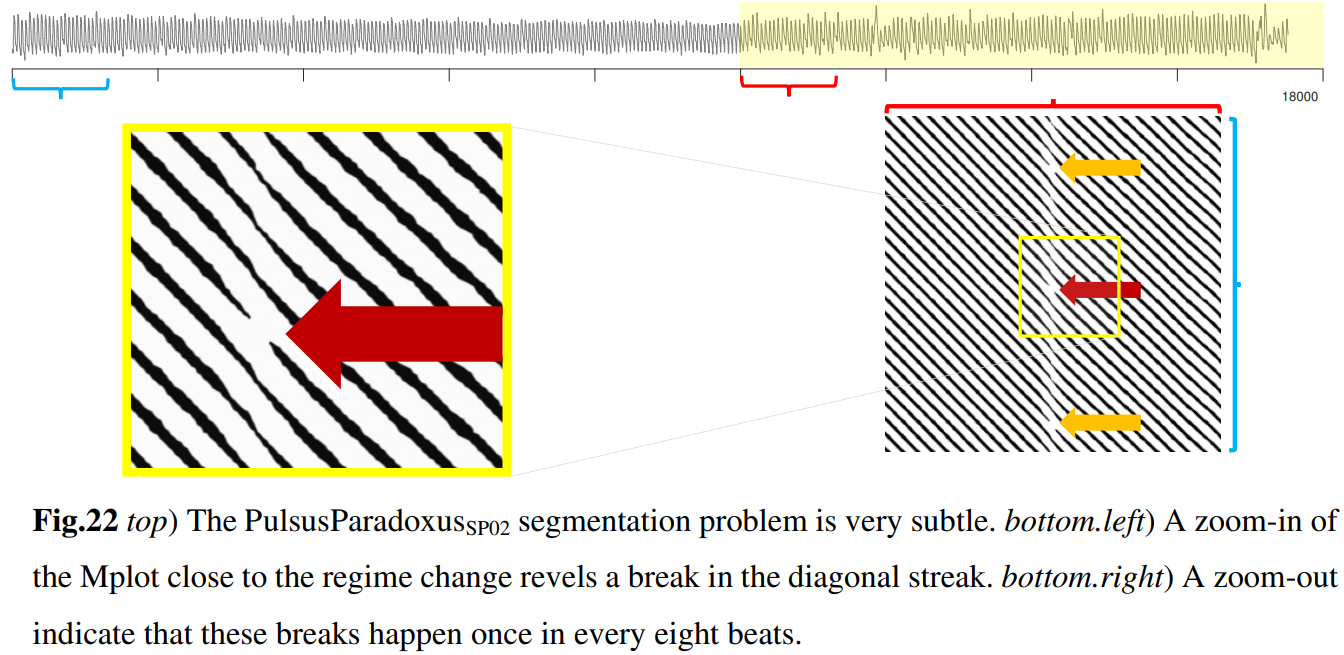

In [45]:
fraction = 18000/(9*ts_step)
print(fraction)
approximated_position_in_eamonn_plot = 6*fraction + (fraction/2)
print(f"Approximated position in eammon's plot {approximated_position_in_eamonn_plot}")

1000.0
Approximated position in eammon's plot 6500.0


In [110]:
sequences_len = int(np.ceil(2*fraction/3))
sequences_len

667

In [123]:
blue_final = int(sequences_len)
print(f"blue {0}-{blue_final}")
blue_sequence = ts[0:blue_final]
red_init = int(fraction*5)
red_final = red_init+sequences_len
print(f"red {red_init}-{red_final}")
red_sequence = ts[red_init:red_final]
init = max(0, pulsus_mp.motif_idx -m)
final = int(init+sequences_len)
print(f"mp {init}-{final}")
mp_sequence = ts[init:final]

blue 0-667
red 5000-5667
mp 5765-6432


##### Motif found by MP

Motif found using MP
Plotted: ts[5765,6432] => 5818 subsequence index changes to 53


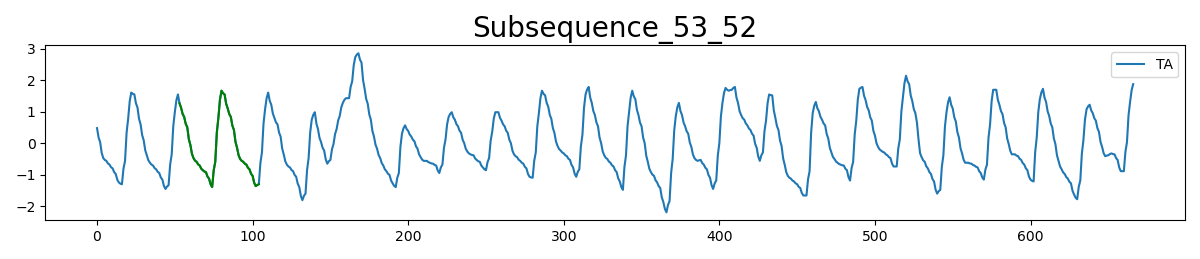

In [124]:
print("Motif found using MP")
id = pulsus_mp.get_ordered_idx(3)
print(f"Plotted: ts[{init},{final}] => {id} subsequence index changes to {id-init}")

mplots.plot_subsequence(
    TA = mp_sequence, 
    sequence_i = id-init,
    subsequence_len = pulsus_mp.subsequence_len,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    plot_name = "mp_motif"
)

#### Red subsequence

Red subsequence
Plotted: ts[5000,5667] => 5333 subsequence index changes to 333


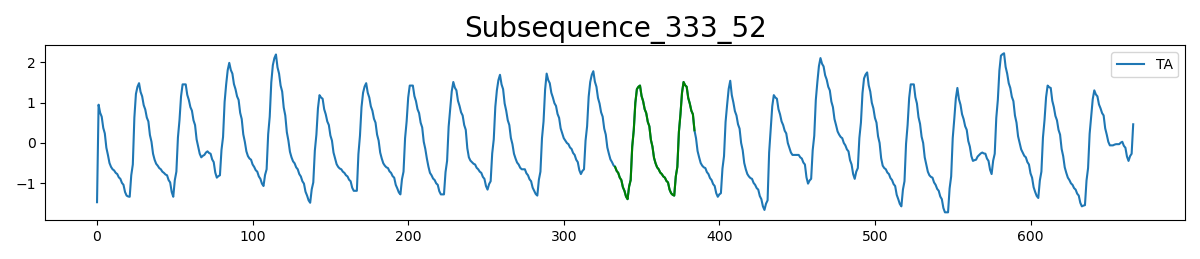

In [125]:
print("Red subsequence")
pos = int( red_init+(sequences_len/2) )
print(f"Plotted: ts[{red_init},{red_final}] => {pos} subsequence index changes to {pos-red_init}")

mplots.plot_subsequence(
    TA = red_sequence, 
    sequence_i = int(sequences_len/2),
    subsequence_len = pulsus_mp.subsequence_len,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)


#### Blue subsequence

The motif is found each 8 beats. The first seem to be in the fourth beat. Let's check.

Take special care as in the plot they are computing with time steps of 2 for some case
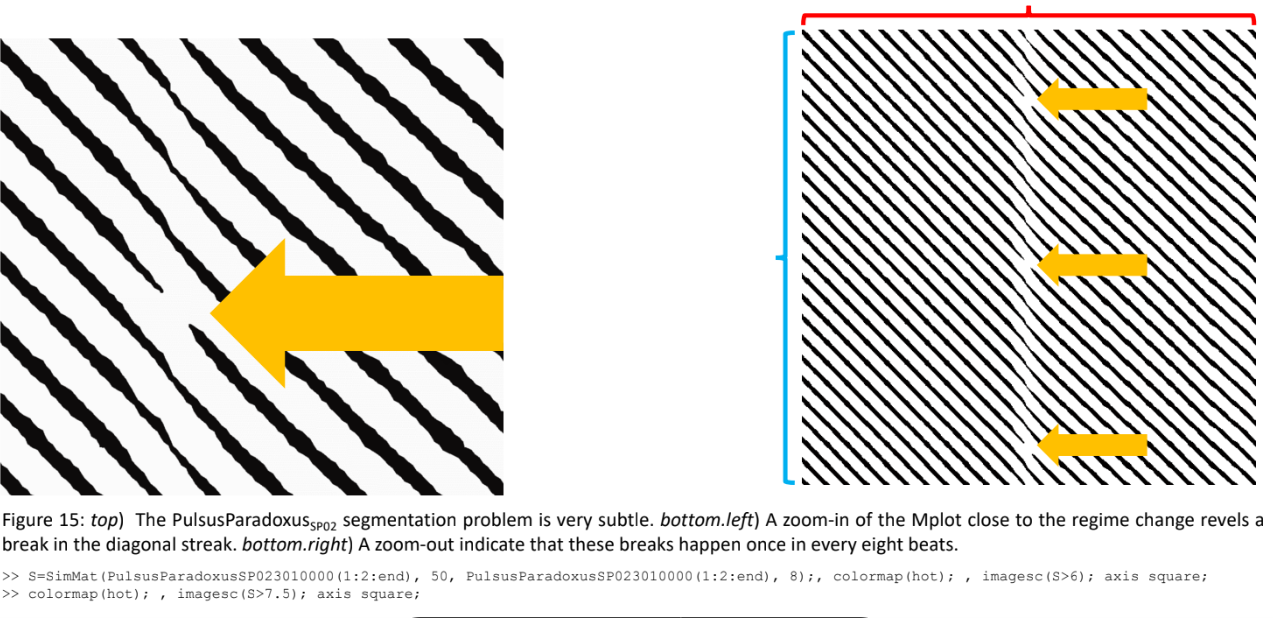

In [96]:
pulsus_mp.subsequence_len

52

Blue subsequence


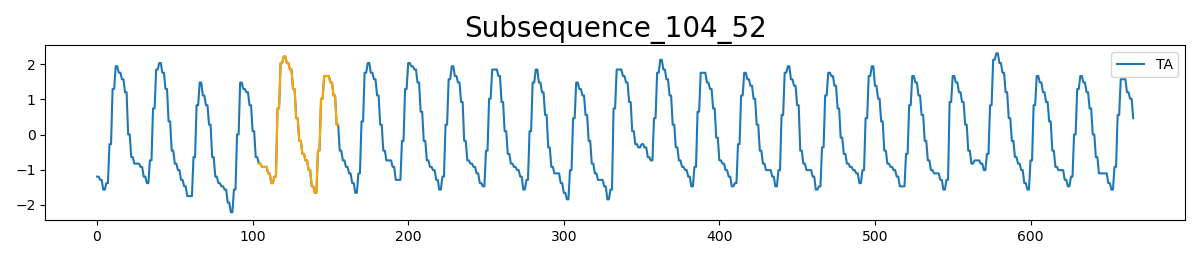

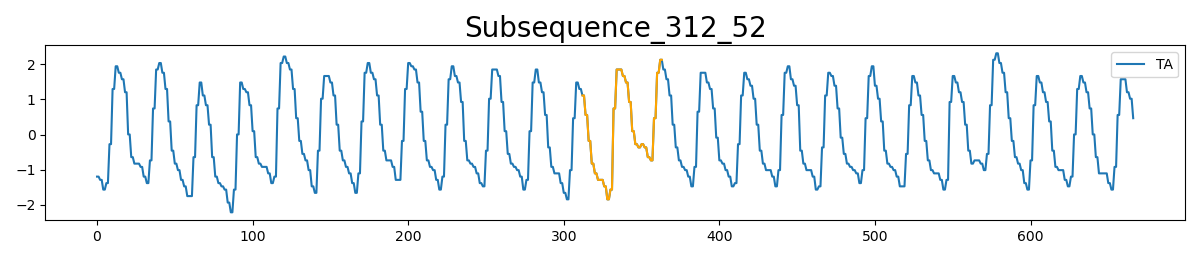

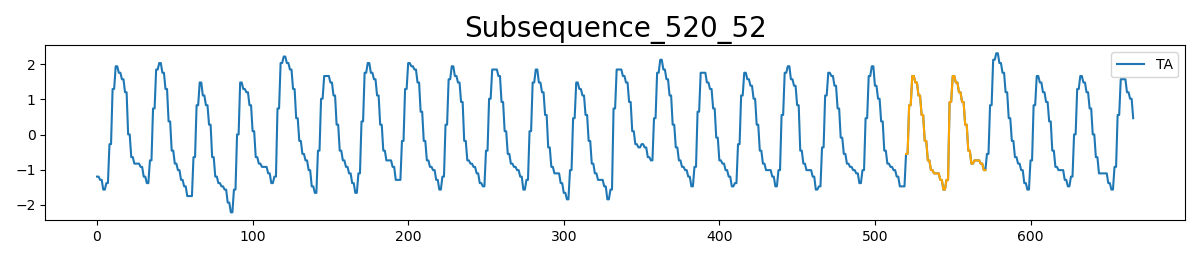

In [126]:
print("Blue subsequence")
first_i = int(4*pulsus_mp.subsequence_len)
m = pulsus_mp.subsequence_len
mplots.plot_subsequence(
    TA = blue_sequence, 
    sequence_i = int(4*m/ts_step),
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    subsequence_color = "orange"
)
mplots.plot_subsequence(
    TA = blue_sequence, 
    sequence_i = int((4*m+8*m)/ts_step),
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    subsequence_color = "orange"
)
mplots.plot_subsequence(
    TA = blue_sequence, 
    sequence_i = int((4*m+16*m)/ts_step),
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    subsequence_color = "orange"
)


Before: Pos 0 Add 0
Plot Interactive | After: Pos 0 Selected index 5817
Plot Interactive | Distances:  [0.7133067490755893 0.7019061719071555 0.6899289065110475 ...
 0.7250217071761418 0.7153993301984543 0.7365570025220421]
Plot Interactive | Window [4317, 7317]


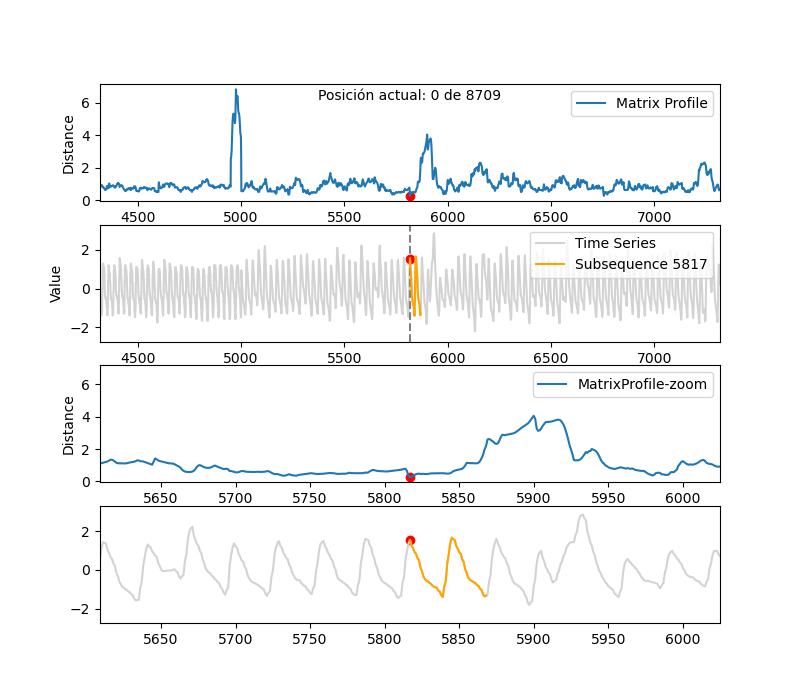

In [52]:
%matplotlib widget
# Max points to plot
pulsus_MPlot.MP_AB.max_points = 3000
pulsus_MPlot.MP_AB.plot_interactive(verbose = 1, figsize=(8,7))

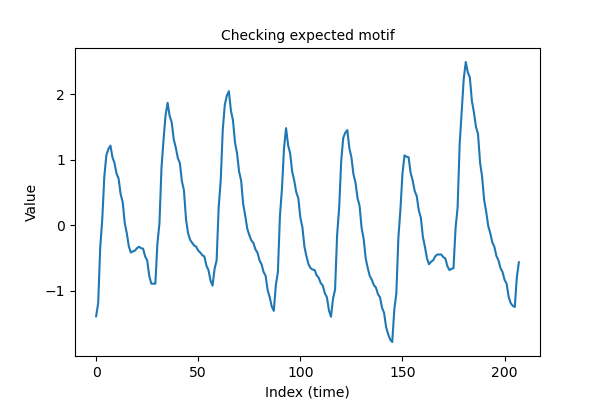

In [53]:
t0 = int(max(0,np.floor(approximated_position_in_eamonn_plot-pulsus_MPlot.subsequence_len*2)))
t1 = int(min(np.ceil(approximated_position_in_eamonn_plot+pulsus_MPlot.subsequence_len*2), len(pulsus_MPlot.data)))
mplots.plot_with_dots(
    time_series = pulsus_MPlot.data[t0:t1],
    title = "Checking expected motif", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False,
    figsize = (6,4)
)

It seems to be a very similar subsequence. Can't compute the distance as I don't know the correct initial index.

#### Setting up a threshold

It has been checked that, at least for pulsus raxodus, STUMP separates more the distances than SCAMP, so the proposed thresholds show similar plots for the specific case.

In [54]:
# Threshold per method
threshold_scamp = 10.72
threshold_stump = 7.6
#Select the threshold for the method used for the computation
threshold = threshold_stump if pulsus_MPlot.DM_AB.method == 'stump' else threshold_scamp

#### Visualizing the MPlot in gray scale

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;TODO: check, the gray_color flag is in the opposite way... 
    </div>
</div>

Threshold: 7.6 | Mehod: stump


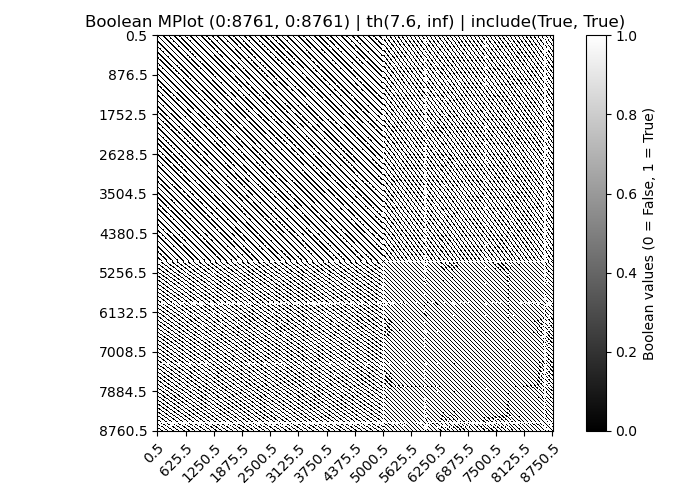

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [55]:
print(f"Threshold: {threshold} | Mehod: {pulsus_MPlot.DM_AB.method}")

pulsus_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = threshold,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'Variable 0: MPlot | ' + pulsus_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = False
)

#### Zoom!

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;Remember that in MPlots zooming in-out is not recommended due to the approximations. Thus. We directly show the specific part 
    </div>
</div>

In [56]:
spaces_len = int(18000/9)
print(spaces_len)
sequence_len = int(np.ceil(2*spaces_len/3))
print(sequence_len)
#sequence_len = int(sequence_len/ts_step)
#print(sequence_len)

2000
1334


In [57]:
#Pattern location following Eamonn et al.
c_min = int((np.floor(spaces_len*5+spaces_len/2)+2*pulsus_mp.subsequence_len)/ts_step)
c_max = c_min + int(sequence_len/ts_step)
r_min = max(0,int(np.floor(0/ts_step)))
#r_max = min(int(np.ceil(sequence_len/ts_step))+1, pulsus_MPlot.DM_AB.shape[0])
r_max = r_min + int(sequence_len/ts_step)

print(f"R({r_min}, {r_max}) C({c_min}, {c_max}) ")
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

R(0, 667) C(5552, 6219) 
c: (5552, 6219), r: (0, 667)


In [58]:
#Pattern location following Eamonn et al.
c_min = int(np.floor(spaces_len*5/ts_step))+pulsus_mp.subsequence_len
c_max = int(np.ceil((spaces_len*5+sequence_len)/ts_step))+1
r_min = max(0,int(np.floor(0/ts_step)))
r_max = min(int(np.ceil(sequence_len/ts_step))+1, pulsus_MPlot.DM_AB.shape[0])

print(f"R({r_min}, {r_max}) C({c_min}, {c_max}) ")
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

R(0, 668) C(5052, 5668) 
c: (5052, 5668), r: (0, 668)


In [59]:
len(ts)

8761

Threshold:  7.6
Plot check limits | Original range: r( 0 , 1000 ) c( 4500 , 5500 )
Plot check limits | CRange0: r( 0 , 1000 ) c( 4500 , 5500 )
Plot check limits | CRange1: r( 0 , 1000 ) c( 4500 , 5500 )
Plot check limits | CRange2: r( 0 , 1000 ) c( 4500 , 5500 )
Plot check limits | Final range: r( 0 , 1000 ) c( 4500 , 5500 )
r_start 0
r_end 1000
c_start 4500
c_end 5500
nr 1001
nc 1001
MPlot | Plot DM | DM_AB[0:1000, 4500:5500] ~ (0, 8710)
Plotting as MATLAB


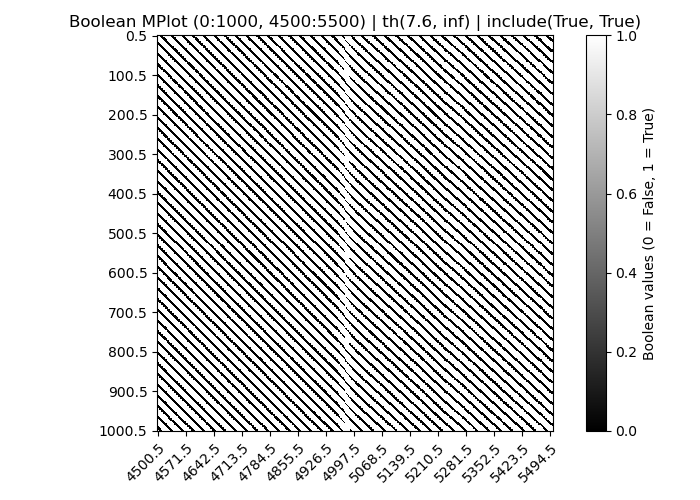

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [60]:
print("Threshold: ", threshold)
pulsus_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    less_labels  = True,
    r_min        = 0,
    r_max        = 1000,
    c_min        = 4500,
    c_max        = 5500,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = False,
    plot_mp_flag = False,
    verbose      = 1
)

#### Zoom with colors!

In [61]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

c: (5052, 5668), r: (0, 668)


Threshold:  7.6
Plot check limits | Original range: r( 0 , 1000 ) c( 4500 , 5500 )
Plot check limits | CRange0: r( 0 , 1000 ) c( 4500 , 5500 )
Plot check limits | CRange1: r( 0 , 1000 ) c( 4500 , 5500 )
Plot check limits | CRange2: r( 0 , 1000 ) c( 4500 , 5500 )
Plot check limits | Final range: r( 0 , 1000 ) c( 4500 , 5500 )
r_start 0
r_end 1000
c_start 4500
c_end 5500
nr 1001
nc 1001
MPlot | Plot DM | DM_AB[0:1000, 4500:5500] ~ (0, 8710)
Plotting as MATLAB


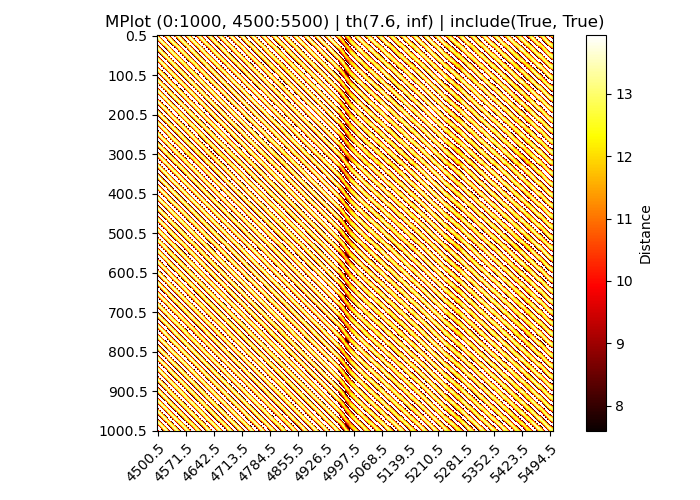

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [62]:
print("Threshold: ", threshold)
pulsus_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    less_labels  = True,
    r_min        = 0,
    r_max        = 1000,
    c_min        = 4500,
    c_max        = 5500,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = True,
    plot_mp_flag = False,
    verbose      = 1
)

#### And what about computing only the part of the plot I need?

In [63]:
pulsus_MPlot2 = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [64]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

c: (5052, 5668), r: (0, 668)


In [65]:
pulsus_MPlot2.compute(
    mp_method           = mp_method,
    dm_method           = dm_method,
    debug               = False,
    time_flag           = True,
    #allow_experimental  = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    c_min               = 0,
    c_max               = 1000,
    r_min               = 4500, 
    r_max               = 5500,
    max_points          = 5000,
    #nlens              = 5,
    subsequence_len     = pulsus_mp.subsequence_len,
    #provide_len        = True,
    provide_len         = False,
    downsample_flag     = True,
    min_lag             = 8,
    verbose=            = 0,
    threads             = 1,
    gpus                = [1]
)

Xpadd 5551, YPadd 1051, A ~ 8761, B ~ 8761
[ MPlot | Compute ] | -->  Downsample 
[ MPlot | Compute ] | Downsample TA ~ 1051 ---> 
[ MPlot | Compute ] | Downsample TB_paa ~ 1051 ---> 
[ MPlot | Compute ] |Downsample -->
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 1051 ---> 
Ensure valid limits | Original [4500, 5551]
Final [4472, 5523]
Ensure valid limits | Original [0, 1051]
Final [0, 1051]
--> matrix profile
Not parallel
matrix profile 2.285616874694824 seconds -->


In [66]:
#pulsus_MPlot.DM_AB.distances[4500:5525,0:1025]
pulsus_MPlot.DM_AB.distances[0:1000,4500:5500]

array([[12.35919525, 11.5749364 , 10.74895505, ..., 12.99973126,
        13.10027793, 13.15194482],
       [12.86790954, 12.37531532, 11.59728633, ..., 12.76865253,
        12.90482459, 13.07647974],
       [13.35996124, 12.88058553, 12.39191588, ..., 12.44931669,
        12.66336259, 12.87568398],
       ...,
       [11.65712428, 10.98251224, 10.00590399, ..., 12.88856875,
        12.85333919, 12.85620975],
       [12.33138854, 11.68721754, 11.0178714 , ..., 12.68906151,
        12.75331722, 12.80802153],
       [12.77421512, 12.3655827 , 11.72900669, ..., 12.42502075,
        12.52899282, 12.70437933]])

In [67]:
pulsus_MPlot2.DM_AB.distances

array([[        inf,         inf,         inf, ..., 12.99973126,
        13.10027793, 13.15194482],
       [        inf,         inf,         inf, ..., 12.76865253,
        12.90482459, 13.07647974],
       [        inf,         inf,         inf, ..., 12.44931669,
        12.66336259, 12.87568398],
       ...,
       [11.65712428, 10.98251224, 10.00590399, ...,         inf,
                inf,         inf],
       [12.33138854, 11.68721754, 11.0178714 , ...,         inf,
                inf,         inf],
       [12.77421512, 12.3655827 , 11.72900669, ...,         inf,
                inf,         inf]])

In [68]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

c: (5052, 5668), r: (0, 668)


In [69]:
print(pulsus_MPlot.DM_AB.shape)
print(pulsus_MPlot2.DM_AB.shape)

(8710, 8710)
(1000, 1000)


<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;Take care... some dyslexia is beeing fixed here. Use columns as rows and rows as columns.
    </div>
</div>

In [70]:
warnings.simplefilter('always', UserWarning)

Threshold:  7.6
Plot check limits | Original range: r( 4500 , 5500 ) c( 0 , 1000 )
Plot check limits | CRange0: r( 4500 , 5500 ) c( 0 , 1000 )
Plot check limits | CRange1: r( 4500 , 5500 ) c( 0 , 1000 )
Plot check limits | CRange2: r( 4500 , 5500 ) c( 0 , 1000 )
Plot check limits | Final range: r( 4500 , 5500 ) c( 0 , 1000 )
r_start 28
r_end 1028
c_start 0
c_end 1000
nr 1001
nc 1001
MPlot | Plot DM | DM_AB[4500:5500, 0:1000] ~ (972, 1000)
Plotting as MATLAB


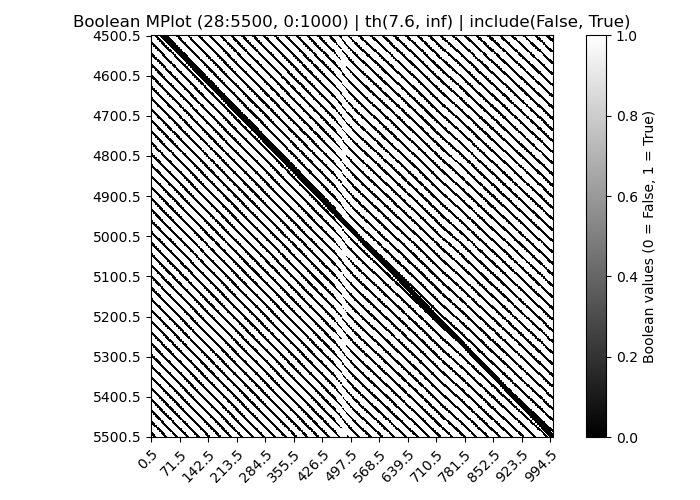

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [71]:
# The mistery of indexes is still being solved
print("Threshold: ", threshold)
pulsus_MPlot2.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    less_labels  = True,
    r_min        = 4500,
    r_max        = 5500,
    c_min        = 0,
    c_max        = 1000,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = False,
    include_max  = True,
    gray_color   = False,
    plot_mp_flag = False,
    verbose      = 1
)

In [72]:
run.finish

<bound method Run.finish of <wandb.sdk.wandb_run.Run object at 0x7f5100357f40>>

In [73]:
if reset_kernel:
    os._exit(00)